데이터 전처리 과정 분석

convert_h36m.py 코드를 통해 h36m_sh_conf_cam_source_final.pkl 파일로부터 clip들을 나누어 data/motion3d/MB3D_f243s81/H36M-SH 폴더에 저장함
그 과정에서 전처리 과정을 거쳐 원본 파일과 새로 생성된 파일의 값이 달라짐 -> 이 부분을 이해해야 AI Hub 데이터를 동일한 형식으로 만들어 훈련시킬 수 있음

In [50]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pickle
import copy
import numpy as np
from tqdm import tqdm
import getpass

os.chdir('/home/hrai/codes/PoseAdaptor')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT/')
from custom_codes.test_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
fit3d_root = '/home/{}/Datasets/HAAI/Fit3D'.format(user)
fit3d_train_root = fit3d_root + '/train'
ap_fit3d_result_root = alphapose_root + "/examples/fit3d_result_2actions"
alphapose_root, motionbert_root, fit3d_root, ap_fit3d_result_root, fit3d_train_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


('/home/hrai/codes/AlphaPose',
 '/home/hrai/codes/MotionBERT',
 '/home/hrai/Datasets/HAAI/Fit3D',
 '/home/hrai/codes/AlphaPose/examples/fit3d_result_2actions',
 '/home/hrai/Datasets/HAAI/Fit3D/train')

### h36m_sh_conf_cam_source_final.pkl 분석

In [2]:
# 원본 파일
with open('data/motion3d/h36m_sh_conf_cam_source_final.pkl', 'rb') as f:
	datareader = pickle.load(f)
datareader.keys()

dict_keys(['train', 'test'])

In [3]:
datareader['train'].keys()

dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'camera_name', 'source'])

In [4]:
datareader['train']['joint_2d'].shape # (1559752, 17, 2) array
datareader['train']['confidence'].shape # (1559752, 17, 1) array
datareader['train']['joint3d_image'].shape # (1559752, 17, 3)
datareader['train']['camera_name'].shape # (1559752,) array
len(datareader['train']['source']) # 1559752 list

1559752

In [5]:
# set(datareader['train']['source']) # s01, s05, s06, s07, s08 / act02 ~ act16 / cam01 ~ cam04
# set(datareader['test']['source']) # s09, s11 / act02 ~ act16 / cam01 ~ cam04

In [6]:
datareader['test'].keys()

dict_keys(['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source'])

In [7]:
datareader['test']['joint_2d'].shape # (566920, 17, 2) array
datareader['test']['confidence'].shape # (566920, 17, 1) array
datareader['test']['joint3d_image'].shape # (566920, 17, 3) array
datareader['test']['joints_2.5d_image'].shape # (566920, 17, 3) array = 2.5d_factor * joint3d_image
datareader['test']['2.5d_factor'].shape # (566920,) array
datareader['test']['camera_name'].shape # (566920,) array
len(datareader['test']['action']) # 566920 list
len(datareader['test']['source']) # 566920 list

566920

In [8]:
datareader['test']['action'][0]

'Direction'

In [9]:
datareader['test']['2.5d_factor'][datareader['test']['camera_name'] == '54138969']

array([4.656527 , 4.6566076, 4.6566916, ..., 2.8969798, 2.9066522,
       2.9163694], dtype=float32)

In [10]:
datareader['test']['joint3d_image'][0][0]*datareader['test']['2.5d_factor'][0] == datareader['test']['joints_2.5d_image'][0][0]

array([ True,  True,  True])

In [11]:
datareader['test']['source'][0]

's_09_act_02_subact_01_ca_01'

In [12]:
datareader['train']['joint3d_image'][0]

array([[473.65402 , 444.887   ,   0.      ],
       [500.99265 , 447.99225 ,  10.409522],
       [479.8339  , 530.7903  ,  54.01511 ],
       [506.21594 , 622.7914  ,  43.28189 ],
       [445.81497 , 441.72488 , -10.409522],
       [456.16095 , 537.1746  ,   8.997781],
       [467.204   , 634.1009  ,  19.16049 ],
       [488.1477  , 397.20285 , -17.641064],
       [480.9083  , 339.6175  , -28.510506],
       [478.3514  , 317.6983  , -16.257427],
       [485.61975 , 296.07678 , -32.04029 ],
       [453.80164 , 359.16058 , -33.806206],
       [429.87262 , 415.5135  , -15.372585],
       [412.80936 , 452.77844 ,  22.879799],
       [508.13965 , 355.9274  , -14.028362],
       [520.3363  , 413.17502 ,  11.877259],
       [515.4759  , 456.40585 ,  47.89767 ]], dtype=float32)

In [13]:
datareader['test']['joints_2.5d_image'][0], datareader['test']['2.5d_factor'][0]

(array([[2099.9255  , 1888.2003  ,    0.      ],
        [2213.828   , 1874.4186  ,   41.11124 ],
        [2234.2285  , 2327.7522  ,  102.769745],
        [2286.4255  , 2773.0183  ,  103.939026],
        [1984.257   , 1902.1954  ,  -41.112675],
        [1962.4642  , 2362.851   ,   11.72006 ],
        [1950.9761  , 2820.1047  ,  -15.964264],
        [2108.8208  , 1636.9973  ,  -57.42959 ],
        [2112.7393  , 1386.3542  , -118.15056 ],
        [2103.3076  , 1273.7389  ,  -95.482635],
        [2125.5537  , 1171.001   , -164.32025 ],
        [1949.586   , 1402.968   , -206.36519 ],
        [1666.3396  , 1468.8893  , -307.63785 ],
        [1405.9584  , 1480.9993  , -326.44434 ],
        [2284.2493  , 1410.1786  ,  -53.34403 ],
        [2540.7769  , 1478.8173  ,   70.194695],
        [2719.2344  , 1502.217   ,  221.90991 ]], dtype=float32),
 4.656527)

In [14]:
datareader['test']['2.5d_factor'][0]

4.656527

In [15]:
datareader['test']['joint3d_image'][0]/1000.0

array([[ 0.45096388,  0.4054954 ,  0.        ],
       [ 0.47542468,  0.40253574,  0.00882873],
       [ 0.47980577,  0.4998902 ,  0.02207004],
       [ 0.4910152 ,  0.59551215,  0.02232115],
       [ 0.42612377,  0.40850088, -0.00882904],
       [ 0.42144376,  0.50742775,  0.00251691],
       [ 0.41897666,  0.605624  , -0.00342836],
       [ 0.45287418,  0.35154894, -0.01233314],
       [ 0.45371562,  0.2977228 , -0.02537311],
       [ 0.45169017,  0.27353838, -0.02050512],
       [ 0.4564676 ,  0.2514752 , -0.03528816],
       [ 0.41867813,  0.30129066, -0.04431741],
       [ 0.3578503 ,  0.3154474 , -0.06606594],
       [ 0.30193284,  0.31804803, -0.07010467],
       [ 0.49054787,  0.3028391 , -0.01145575],
       [ 0.54563767,  0.31757945,  0.01507447],
       [ 0.5839619 ,  0.3226046 ,  0.04765567]], dtype=float32)

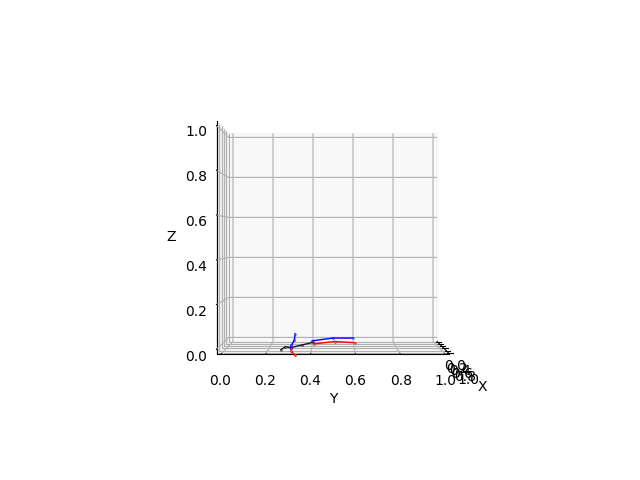

In [16]:
%matplotlib widget

# skeleton 방향 확인
fig = plt.figure(0)
fig.clear()
ax = axes_3d(fig=fig, xlim=(0, 1), ylim=(0, 1), zlim=(0, 1))
#draw_3d_pose(ax, datareader['test']['joints_2.5d_image'][0]/datareader['test']['2.5d_factor'][0]/1000.0, dataset='h36m')
draw_3d_pose(ax, datareader['test']['joint3d_image'][0]/1000.0, dataset='h36m')
plt.show()

### generate pkl for each video in Fit3D

In [13]:
subjects = ['s03', 's08', 's07', 's05', 's10', 's09', 's04', 's11']
action_list = [item.split('.')[0] for item in os.listdir('/home/hrai/Datasets/HAAI/Fit3D/train/s10/videos/50591643')]
test_action = ['pushup', 'burpees', 'squat']
mm_to_m = 1000
use_gt_2d = True
data_type = 'train'
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/FIT3D'

for subject in subjects:
    #print(subject)
    subject_path = os.path.join(fit3d_train_root, subject)
    video_path = os.path.join(subject_path, 'videos')
    for cam_num in os.listdir(video_path):
        cam_path = os.path.join(video_path, cam_num)
        #print(cam_path)
        for action in action_list:
            file_name = '{}_{}_{}.pkl'.format(subject, cam_num, action)
            save_path = os.path.join(save_folder, file_name)
            if os.path.exists(save_path): 
                print(save_path, 'already exist')
                continue

            if action in test_action: data_type = 'test'
            else: data_type = 'train'
            source = '{}_{}_{}_{}'.format(data_type, subject, cam_num, action)

            gt_3d, camera_param = fit3d_load_gt_and_param(fit3d_root, data_type, subject, action, cam_num)
            fx = camera_param['intrinsic'][0, 0]  
            fy = camera_param['intrinsic'][1, 1]  
            cx = camera_param['intrinsic'][0, 2]  
            cy = camera_param['intrinsic'][1, 2] 
            
            num_frames = len(gt_3d)
            data = {}
            for key in ['joint_2d', 'confidence', 'joint3d_image', 'joints_2.5d_image', '2.5d_factor', 'camera_name', 'action', 'source', 'frame', 'world_3d', 'cam_3d', 'cam_param']:
                data[key] = []
            for frame_num in tqdm(range(num_frames)):
                # check whether gt is available
                try: test = np.array(gt_3d[frame_num])[:17, :]
                except: continue

                # joint3d_image
                world_3d = np.array(gt_3d[frame_num])[:17, :] # (17, 3)
                
                # world to camera
                pos = copy.deepcopy(world_3d)
                cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
                cam_3d_hat = get_rootrel_pose(cam_3d)

                # camera to image
                box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
                img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
                #img_2d_hat = get_rootrel_pose(img_2d) # (17, 2) # root-relative pose 
                img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 

                # 2.5d factor
                pred_lambda = optimize_scaling_factor(img_3d_hat, cam_3d_hat) # x,y,z 사용

                # joint 2.5d image
                img_25d = img_3d * pred_lambda
                #img_25d_hat = get_rootrel_pose(img_25d)

                # store
                data['joint_2d'].append(np.array(img_2d).copy()) 
                data['confidence'].append(np.ones(17)) 
                data['joint3d_image'].append(np.array(img_3d).copy()) 
                data['joints_2.5d_image'].append(np.array(img_25d).copy()) 
                data['2.5d_factor'].append(np.array(pred_lambda).copy()) 
                data['camera_name'].append(np.array(cam_num).copy()) 
                data['action'].append(np.array(action).copy()) 
                data['source'].append(np.array(source).copy()) 
                data['frame'].append(np.array(frame_num).copy()) 
                data['world_3d'].append(np.array(world_3d).copy()) 
                data['cam_3d'].append(np.array(cam_3d).copy()) 
                data['cam_param'].append(np.array(camera_param).copy()) 

            # save
            savepkl(data, save_path)
    

/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_dumbbell_biceps_curls.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_drag_curl.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_warmup_5.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_w_raise.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_standing_ab_twists.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_dumbbell_scaptions.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_warmup_6.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_warmup_18.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_warmup_3.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_barbell_shrug.pkl already exist
/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_50591643_warmup_1.pkl already

100%|██████████| 1034/1034 [00:20<00:00, 49.65it/s]


/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_58860488_dumbbell_biceps_curls.pkl already exist


100%|██████████| 1034/1034 [00:21<00:00, 49.16it/s]


/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_60457274_dumbbell_biceps_curls.pkl already exist


100%|██████████| 1034/1034 [00:20<00:00, 51.21it/s]


/home/hrai/codes/MotionBERT/data/motion3d/FIT3D/s03_65906101_dumbbell_biceps_curls.pkl already exist


100%|██████████| 1143/1143 [00:23<00:00, 49.27it/s]


### fit3d_all_train_except_target_action.pkl 생성

In [90]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

subjects = ['s03', 's08', 's07', 's05', 's10', 's09', 's04', 's11']
train_subjects = subjects
test_subjects = subjects
action_list = [item.split('.')[0] for item in os.listdir('/home/hrai/Datasets/HAAI/Fit3D/train/s10/videos/50591643')]
test_action = ['pushup', 'burpees', 'squat']
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_pkl'

for item in tqdm(os.listdir(pkl_folder)):
    #print(item)
    subject, cam_num, action = item[:3], item[4:12], item[13:-4]
    #print(subject, cam_num, action)
    item_path = os.path.join(pkl_folder, item)
    data = readpkl(item_path)
    #print(data.keys())
    if action in test_action: data_type = 'test'
    else: data_type = 'train'
    joint_2ds[data_type] += data['joint_2d']
    confidences[data_type] += data['confidence']
    joint3d_images[data_type] += data['joint3d_image']
    joints_25d_images[data_type] += data['joints_2.5d_image']
    _25d_factors[data_type] += data['2.5d_factor']
    camera_names[data_type] += data['camera_name']
    actions[data_type] += data['action']
    sources[data_type] += data['source']
    frames[data_type] += data['frame']
    world_3ds[data_type] += data['world_3d']
    cam_3ds[data_type] += data['cam_3d']
    cam_params[data_type] += data['cam_param']

100%|██████████| 1504/1504 [00:21<00:00, 69.02it/s]


In [44]:
fit3d_all_train_except_target_action = {'train': {}, 'test': {}}

same_as_train = False
for data_type in ['train', 'test']:
    data_type_ = data_type
    if same_as_train:
        data_type_ = 'train'
    fit3d_all_train_except_target_action[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    fit3d_all_train_except_target_action[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    fit3d_all_train_except_target_action[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    fit3d_all_train_except_target_action[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    fit3d_all_train_except_target_action[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    fit3d_all_train_except_target_action[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    fit3d_all_train_except_target_action[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    fit3d_all_train_except_target_action[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    fit3d_all_train_except_target_action[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    fit3d_all_train_except_target_action[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    fit3d_all_train_except_target_action[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    fit3d_all_train_except_target_action[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))

In [49]:
print(len(fit3d_all_train_except_target_action['train']['joint_2d']), len(fit3d_all_train_except_target_action['test']['joint_2d']))

1666432 112860


In [50]:
save_path = os.path.join(motionbert_root, 'data/motion3d/fit3d_all_train_except_target_action.pkl')
savepkl(fit3d_all_train_except_target_action, save_path)

### fit3d_target_action.pkl

In [9]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

subjects = ['s03', 's08', 's07', 's05', 's10', 's09', 's04', 's11']
train_subjects = subjects
test_subjects = subjects
action_list = [item.split('.')[0] for item in os.listdir('/home/hrai/Datasets/HAAI/Fit3D/train/s10/videos/50591643')]
test_action = ['pushup', 'burpees', 'squat']
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_pkl'

for item in tqdm(os.listdir(pkl_folder)):
    #print(item)
    subject, cam_num, action = item[:3], item[4:12], item[13:-4]
    #print(subject, cam_num, action)
    item_path = os.path.join(pkl_folder, item)
    data = readpkl(item_path)
    #print(data.keys())
    if action in test_action: data_type = 'train'
    else: continue
    joint_2ds[data_type] += data['joint_2d']
    confidences[data_type] += data['confidence']
    joint3d_images[data_type] += data['joint3d_image']
    joints_25d_images[data_type] += data['joints_2.5d_image']
    _25d_factors[data_type] += data['2.5d_factor']
    camera_names[data_type] += data['camera_name']
    actions[data_type] += data['action']
    sources[data_type] += data['source']
    frames[data_type] += data['frame']
    world_3ds[data_type] += data['world_3d']
    cam_3ds[data_type] += data['cam_3d']
    cam_params[data_type] += data['cam_param']

100%|██████████| 1504/1504 [00:21<00:00, 69.39it/s]


In [10]:
fit3d_test_target_action = {'train': {}, 'test': {}}

same_as_train = True
for data_type in ['train', 'test']:
    data_type_ = data_type
    if same_as_train:
        data_type_ = 'train'
    fit3d_test_target_action[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    fit3d_test_target_action[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    fit3d_test_target_action[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    fit3d_test_target_action[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    fit3d_test_target_action[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    fit3d_test_target_action[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    fit3d_test_target_action[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    fit3d_test_target_action[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    fit3d_test_target_action[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    fit3d_test_target_action[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    fit3d_test_target_action[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    fit3d_test_target_action[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))

In [11]:
print(len(fit3d_test_target_action['train']['joint_2d']), len(fit3d_test_target_action['test']['joint_2d']))

112860 112860


In [12]:
save_path = os.path.join(motionbert_root, 'data/motion3d/fit3d_test_target_action.pkl')
savepkl(fit3d_test_target_action, save_path)

### Alphapose test pkl

In [13]:
joint_2ds = {'train': [], 'test': []}
confidences = {'train': [], 'test': []}
joint3d_images = {'train': [], 'test': []}
joints_25d_images = {'train': [], 'test': []}
_25d_factors = {'train': [], 'test': []}
camera_names = {'train': [], 'test': []}
actions = {'train': [], 'test': []}
sources = {'train': [], 'test': []}
frames = {'train': [], 'test': []}
world_3ds = {'train': [], 'test': []}
cam_3ds = {'train': [], 'test': []}
cam_params = {'train': [], 'test': []}

subjects = ['s03', 's08', 's07', 's05', 's10', 's09', 's04', 's11'] # ['s02', 's12', 's13']
train_subjects = subjects
test_subjects = subjects
action_list = [item.split('.')[0] for item in os.listdir('/home/hrai/Datasets/HAAI/Fit3D/train/s10/videos/50591643')]
test_action = ['pushup', 'burpees', 'squat']
pkl_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_pkl'
ap_result_folder = '/home/hrai/codes/AlphaPose/examples/fit3d_result_3actions'

for item in tqdm(os.listdir(pkl_folder)):
    subject, cam_num, action = item[:3], item[4:12], item[13:-4]
    if action not in test_action: continue
    if subject in train_subjects: data_type = 'train'
    else: data_type = 'test'
    #print(subject, cam_num, action)
    item_path = os.path.join(pkl_folder, item)
    data = readpkl(item_path)
    gt_3d, camera_param = fit3d_load_gt_and_param(fit3d_root, data_type, subject, action, cam_num)
    file_name = 'res_{}_{}_{}_{}'.format(data_type, subject, cam_num, action)
    #print(file_name)
    ap_result = readJSON(os.path.join(ap_result_folder, file_name, 'alphapose-results.json'))
    #print(ap_result[0])
    #print('ap num: ', len(ap_result), 'gt num: ', len(data['joint_2d']))

    # alphapose 결과 추출
    id_list = []
    new_joint_2ds = []
    new_confidences = []
    for frame in ap_result:
        image_id = int(frame['image_id'].split('.')[0])
        if image_id in id_list: continue # 중복 image_id 제거
        if image_id >= len(data['joint_2d']): continue # image_id가 gt의 길이보다 길면 제거
        #print(image_id)
        id_list.append(image_id)
        keypoints = halpe2h36m(np.array(frame['keypoints']).reshape(1, -1, 3))[0]
        new_joint_2ds.append(keypoints[:, :2])
        new_confidences.append(keypoints[:, 2])
    #print(len(id_list), len(new_joint_2ds), len(new_confidences))
    #print(id_list)
    #print(len(data['joint3d_image']))

    joint_2ds[data_type]         += new_joint_2ds
    confidences[data_type]       += new_confidences
    joint3d_images[data_type]    += list(np.array(data['joint3d_image'])[id_list])
    joints_25d_images[data_type] += list(np.array(data['joints_2.5d_image'])[id_list])
    _25d_factors[data_type]      += list(np.array(data['2.5d_factor'])[id_list])
    camera_names[data_type]      += list(np.array(data['camera_name'])[id_list])
    actions[data_type]           += list(np.array(data['action'])[id_list])
    sources[data_type]           += list(np.array(data['source'])[id_list])
    frames[data_type]            += list(np.array(data['frame'])[id_list])
    world_3ds[data_type]         += list(np.array(data['world_3d'])[id_list])
    cam_3ds[data_type]           += list(np.array(data['cam_3d'])[id_list])
    cam_params[data_type]        += list(np.array(data['cam_param'])[id_list])
    #break

100%|██████████| 1504/1504 [00:10<00:00, 146.26it/s]


In [18]:
fit3d_target_action_test_with_ap = {'train': {}, 'test': {}}

same_as_train = True
for data_type in ['train', 'test']:
    data_type_ = data_type
    if same_as_train:
        data_type_ = 'train'
    fit3d_target_action_test_with_ap[data_type]['joint_2d']          = copy.deepcopy(np.array(joint_2ds[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['confidence']        = copy.deepcopy(np.array(confidences[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['joint3d_image']     = copy.deepcopy(np.array(joint3d_images[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['joints_2.5d_image'] = copy.deepcopy(np.array(joints_25d_images[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['2.5d_factor']       = copy.deepcopy(np.array(_25d_factors[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['camera_name']       = copy.deepcopy(np.array(camera_names[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['action']            = copy.deepcopy(np.array(actions[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['source']            = copy.deepcopy(np.array(sources[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['frame']             = copy.deepcopy(np.array(frames[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['world_3d']          = copy.deepcopy(np.array(world_3ds[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['cam_3d']            = copy.deepcopy(np.array(cam_3ds[data_type_]))
    fit3d_target_action_test_with_ap[data_type]['cam_param']         = copy.deepcopy(np.array(cam_params[data_type_]))

In [19]:
for key in fit3d_target_action_test_with_ap[data_type].keys():
    print(key, len(fit3d_target_action_test_with_ap['train'][key]), len(fit3d_target_action_test_with_ap['test'][key]))

joint_2d 109753 109753
confidence 109753 109753
joint3d_image 109753 109753
joints_2.5d_image 109753 109753
2.5d_factor 109753 109753
camera_name 109753 109753
action 109753 109753
source 109753 109753
frame 109753 109753
world_3d 109753 109753
cam_3d 109753 109753
cam_param 109753 109753


In [20]:
fit3d_target_action_test_with_ap['test']['joint_2d'].shape

(109753, 17, 2)

In [ ]:
fit3d_target_action_test_with_ap

In [17]:
save_path = os.path.join(motionbert_root, 'data/motion3d/fit3d_test_target_action_with_ap.pkl')
savepkl(fit3d_target_action_test_with_ap, save_path)

In [24]:
readpkl(save_path)['train']['joint_2d'].shape

(109753, 17, 2)

### Compare fit3d_test_target_action_with_ap and fit3d_all_train_except_target_action

In [5]:
fit3d_all_train_except_target_action = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/fit3d_all_train_except_target_action.pkl')
fit3d_test_target_action_with_ap = readpkl('/home/hrai/codes/MotionBERT/data/motion3d/fit3d_test_target_action_with_ap.pkl')

In [7]:
fit3d_all_train_except_target_action['train']['joint_2d'].shape, fit3d_all_train_except_target_action['test']['joint_2d'].shape

((1666432, 17, 2), (112860, 17, 2))

In [8]:
fit3d_test_target_action_with_ap['train']['joint_2d'].shape, fit3d_test_target_action_with_ap['test']['joint_2d'].shape

((109753, 17, 2), (109753, 17, 2))

### Visualization

In [8]:
fit3d_root

'/home/hrai/Datasets/HAAI/Fit3D'

In [65]:
frame_num = 0

gt_3d, camera_param_50591643 = fit3d_load_gt_and_param(fit3d_root, 'train', 's03', 'pushup', '50591643')
world_3d = np.array(gt_3d[frame_num])[:17, :]

Cs = []
ts = []
img_2ds = []
cameras = []
cam_list = ['50591643', '58860488', '60457274', '65906101']

for cam in cam_list:
    gt_3d, camera_param = fit3d_load_gt_and_param(fit3d_root, 'train', 's03', 'pushup', cam)
    extrinsic_matrix = camera_param['extrinsic']
    intrinsic_matrix = camera_param['intrinsic']
    t = extrinsic_matrix[:3, 3]
    R = extrinsic_matrix[:3, :3]
    C = - R.T @ t
    keypoints_3d_cam = World2CameraCoordinate(world_3d.copy(), extrinsic_matrix)
    keypoints_proj = (intrinsic_matrix @ keypoints_3d_cam.copy().T).T
    keypoints_proj /= np.repeat(keypoints_proj[:, 2].reshape(-1, 1), 3, axis=1)
    cam_origin = C

    forward = [1, 0, 0]
    left = [0, -1, 0]
    up = np.cross(forward, left)
    cam_default_R = np.array([left, up, forward]) # default camera orientation

    camera = Camera(origin=cam_origin, 
                    calib_mat=intrinsic_matrix, 
                    cam_default_R=R, 
                    roll=0,
                    pitch=0,
                    yaw=0,
                    IMAGE_HEIGHT=1000, 
                    IMAGE_WIDTH=1000,
                    cam_name=cam)
    
    Cs.append(C)
    ts.append(t)
    img_2ds.append(keypoints_proj)
    cameras.append(camera)

[111.85419034   2.34327685 101.30407527]
[ 61.65461688   0.56760598 100.15727475]
[-65.00656443  -0.55550461  99.59659077]
[-115.43979507    0.13552381  101.22197109]


In [63]:
Rotation.from_matrix(R).as_euler('xyz', degrees=True)

array([-114.81247659,   62.37104857,  157.86369508])

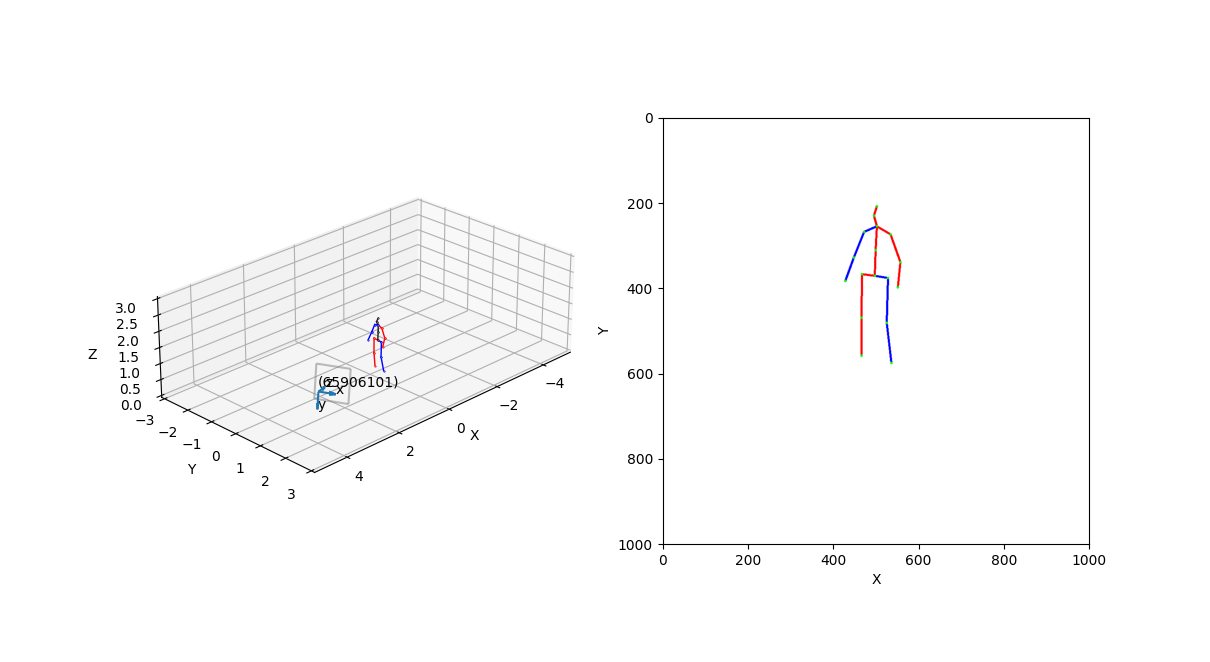

In [52]:
%matplotlib widget
# draw 3d pose and camera frame
fig = plt.figure(1)
fig.clear()

ax1 = axes_3d(fig=fig, loc=121, xlim=(-5, 5), ylim=(-3, 3), zlim=(0, 3), view=[25, 45])
plt.sca(ax1)
draw_3d_pose(ax1, world_3d, dataset='fit3d')
camera.cam_frame.draw3d()
#camera.image_frame.draw3d()
camera.image_plane.draw3d()

ax2 = axes_2d(fig=fig, loc=122)
plt.sca(ax2)
img = get_2d_pose_image(keypoints_proj, dataset='h36m')
ax2.imshow(img)

plt.show()

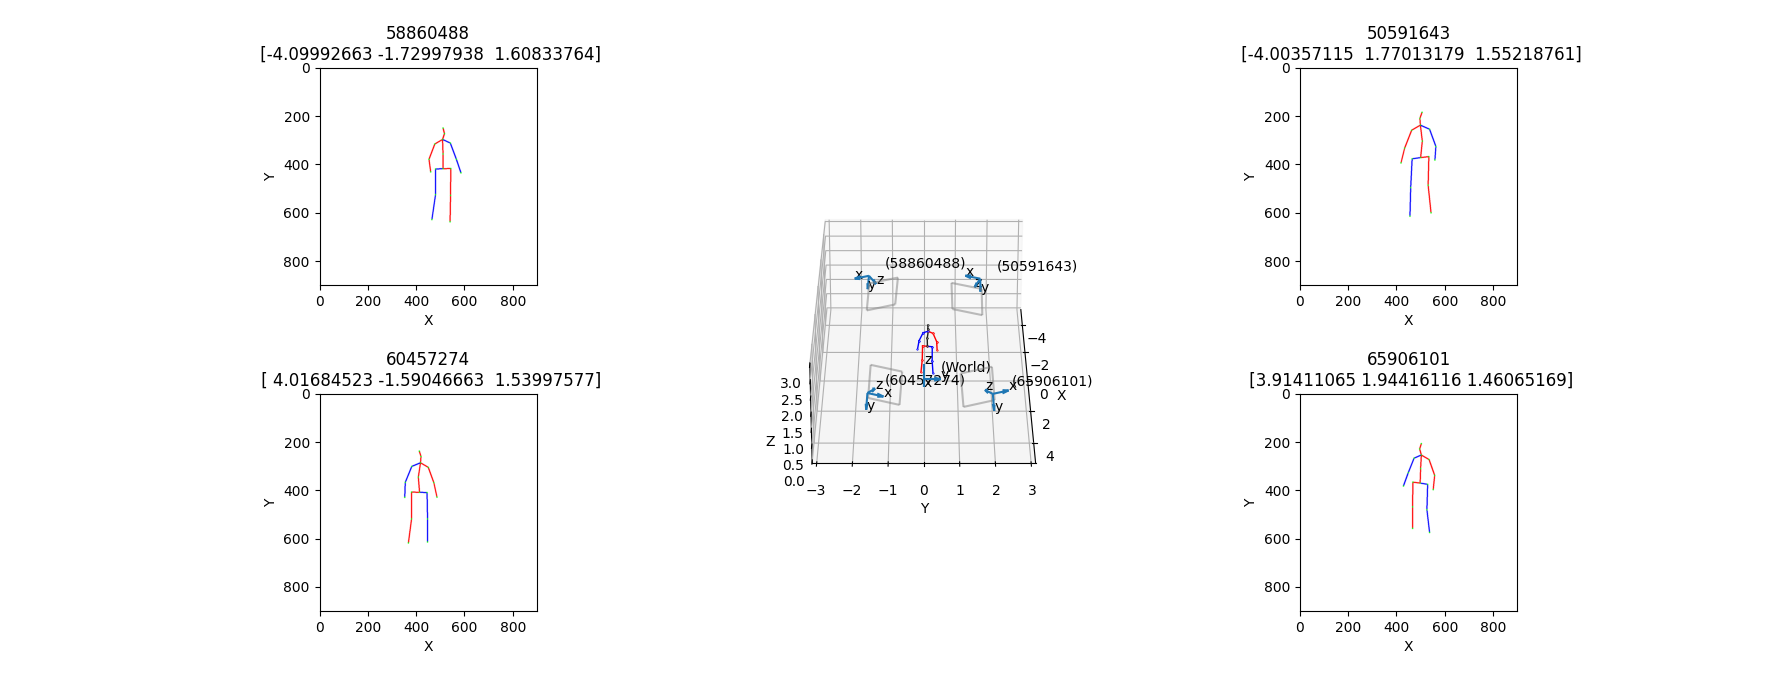

In [61]:
%matplotlib widget
# draw 3d pose and camera frame
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
fig = plt.figure(2)
fig.clear()

world_frame = generate_world_frame()

ax_3d = axes_3d(fig=fig, loc=132, xlim=(-5, 5), ylim=(-3, 3), zlim=(0, 3), view=[25, 0])
ax_cam1 = axes_2d(fig=fig, loc=231, H=900, W=900)
ax_cam2 = axes_2d(fig=fig, loc=233, H=900, W=900)
ax_cam3 = axes_2d(fig=fig, loc=234, H=900, W=900)
ax_cam4 = axes_2d(fig=fig, loc=236, H=900, W=900)

plt.sca(ax_3d)
draw_3d_pose(ax_3d, world_3d, dataset='fit3d')
world_frame.draw3d()
for i in range(4):
    cameras[i].cam_frame.draw3d()
    #cameras[i].image_frame.draw3d()
    cameras[i].image_plane.draw3d()


plt.sca(ax_cam1)
img = get_2d_pose_image(img_2ds[1], dataset='h36m')
ax_cam1.imshow(img)
ax_cam1.set_title('{}\n {}'.format(cam_list[1], Cs[1]))

plt.sca(ax_cam2)
img = get_2d_pose_image(img_2ds[0], dataset='h36m')
ax_cam2.imshow(img)
ax_cam2.set_title('{}\n {}'.format(cam_list[0], Cs[0]))

plt.sca(ax_cam3)
img = get_2d_pose_image(img_2ds[2], dataset='h36m')
ax_cam3.imshow(img)
ax_cam3.set_title('{}\n {}'.format(cam_list[2], Cs[2]))

plt.sca(ax_cam4)
img = get_2d_pose_image(img_2ds[3], dataset='h36m')
ax_cam4.imshow(img)
ax_cam4.set_title('{}\n {}'.format(cam_list[3], Cs[3]))

plt.show()